# Machine learning and multivariate Monte Carlo simulation

## Packages importations

In [29]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap

## Data importation and preprocessing

In [30]:
data = pd.read_excel(r'c:\Users\ACER\Documents\Projet IA\Datasets\Carbone_data.xlsx') ###Importations 
df = data[['plot_id', 'Carbon', 'NDVI', 'tree_prop', 'NDWI', 'LST', 'precip']] ##Selection of key variables 
df['Carbon_ha'] = df['Carbon']/400 ##Area normalization of carbon value 

C:\Users\ACER\AppData\Local\Temp\ipykernel_11200\2617704097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Carbon_ha'] = df['Carbon']/400 ##Area normalization of carbon value


In [31]:
y = df['Carbon_ha'] ##y values 
x = df.drop(['Carbon_ha', 'Carbon'], axis = 1) ##x values 

##split of data 
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 23)

##Cleaning of dataset 
groups_train = x_train['plot_id'] ##ID for spatial cross validation
x_train_clean = x_train.drop(['plot_id'], axis = 1)  ##Cleaning of train data 
x_test_clean = x_test.drop(['plot_id'], axis = 1) ## Cleaning of test data 

## Machine Learning

### Packages importations

In [32]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

### Models specifications

In [33]:
models = {
    'LR' : LinearRegression(), 
    'RF' : RandomForestRegressor(random_state= 23), 
    'GBoost' : GradientBoostingRegressor(learning_rate= 0.05, n_estimators = 100, random_state = 23), 
    'XGB' : xgb.XGBRegressor(learning_rate = 0.05, n_estimators = 100, random_state = 23)
}

### Models training

LR metrics : RMSE = 306.29 ; R² = 0.40


RF metrics : RMSE = 196.63 ; R² = 0.75
GBoost metrics : RMSE = 237.65 ; R² = 0.64
XGB metrics : RMSE = 199.32 ; R² = 0.75


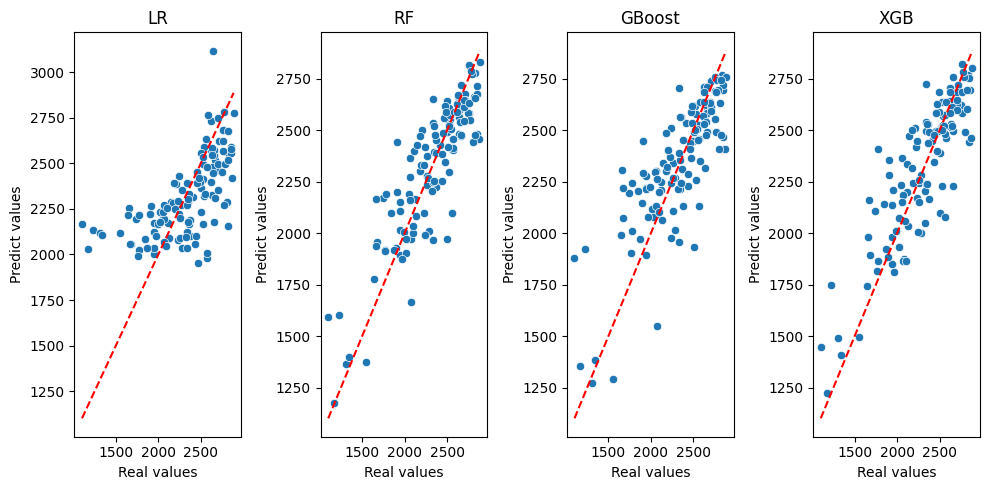

In [34]:
plt.figure(figsize = (10,5))
for i, (name, model) in enumerate(models.items(), 1) : 
    pipe = Pipeline([('Scaler', StandardScaler()), 
                     ('Model', model)]) ##Pipeline implementation 
    
    pipe.fit(x_train_clean, y_train) ##Model training 

    spatial_folds = GroupKFold(n_splits = 5)  ##Spatial folders 

    cv = cross_val_score(pipe, x_train_clean, y_train, groups = groups_train, cv = spatial_folds, scoring = 'r2') ##Cross validation 

    ##Model evaluation 
    y_pred = pipe.predict(x_test_clean) ##Prediction 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) ##RMSE calculation 
    r2 = r2_score(y_test, y_pred) ##R² score calculation 

    print(f'{name} metrics : RMSE = {rmse:.2f} ; R² = {r2:.2f}') ##Metrics displaying 

    ## Graphics 
    plt.subplot(1, len(models), i)
    sns.scatterplot(x = y_test, y = y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Real values')
    plt.ylabel('Predict values')
    plt.title(name)

plt.tight_layout()
plt.show()

## SHAP analysis on the best model

In [35]:
rf_pipe = Pipeline([
    ('Scaler', StandardScaler()), 
    ('Model', RandomForestRegressor(random_state = 42))
]) ##Pipeline

rf_pipe.fit(x_train_clean, y_train) ## Model training 

,steps,"[('Scaler', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


Generating Global Feature Importance Bar Plot (Mean Absolute SHAP value)


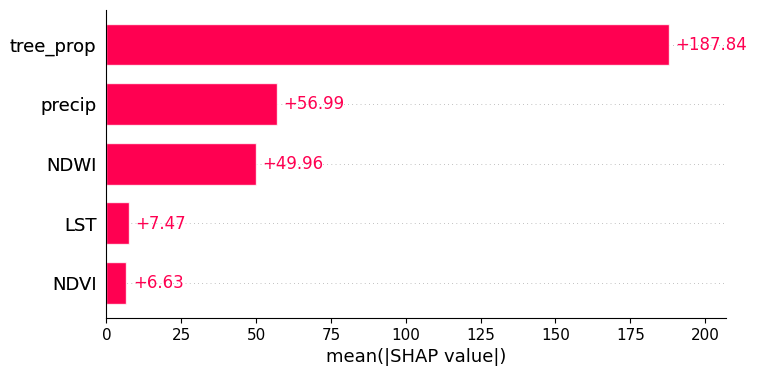

In [36]:
model = rf_pipe.named_steps['Model'] ##Model

# SHAP for RF Model analysis 
explainer = shap.Explainer(model)
shap_values = explainer(x_test_clean)

##Graphic
print("Generating Global Feature Importance Bar Plot (Mean Absolute SHAP value)")
shap.plots.bar(shap_values)
plt.show()

## Monte Carlo simulation (independance approach)

In [82]:
top_vars = ['tree_prop', 'precip', 'NDWI'] ##List of top variables 
n_sim = 10000 ##Number of simulation 
df[top_vars].corr() ##Correlation matrix

,tree_prop,precip,NDWI
tree_prop,1.000000,0.013658,0.436521
precip,0.013658,1.000000,-0.529933
NDWI,0.436521,-0.529933,1.000000


## Scenario of global change

In [ ]:
x_mc = x.drop(['plot_id'], axis=1)  

vuln_mean = []
vuln_p10 = []

for idx in range(len(x_mc)):
    row = x_mc.iloc[idx].copy()
    sim_matrix = np.tile(row.values, (n_sim,1))

    for var in top_vars:
        mu = row[var]
        sigma = abs(mu) * 0.2 / 1.96  # ±20% ≈ IC95%
        sim_matrix[:, x_mc.columns.get_loc(var)] = np.random.normal(mu, sigma, n_sim)

    # Predictions 
    preds_baseline = model.predict(row.values.reshape(1,-1))[0]
    preds_sim = model.predict(sim_matrix)

    # Vulnerability 
    loss = (preds_baseline - preds_sim) / (abs(preds_baseline) + 1e-6)
    
    vuln_p10.append(np.percentile(loss,10))  # Pessimiste scenario vulnerability values 

# Conversion in array 
vuln_p10 = np.array(vuln_p10) 
vuln_norm = (vuln_p10 - vuln_p10.min()) / (vuln_p10.max() - vuln_p10.min()) #Normalisation with Min Max scaling

In [87]:
print(vuln_norm.mean())
print(vuln_norm.max())
print(vuln_norm.min())

0.38690234452815875
1.0
0.0


## Graphics

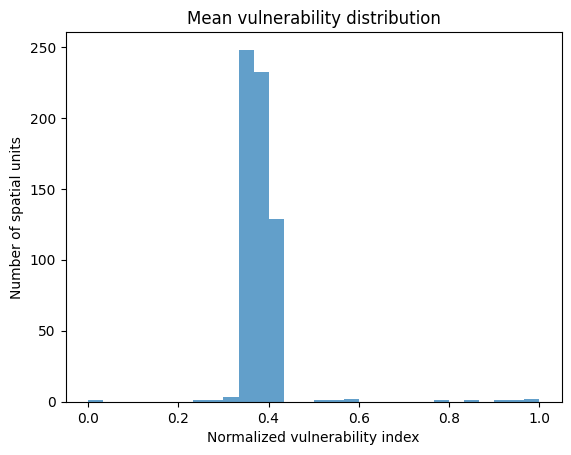

In [85]:
plt.figure()
plt.hist(vuln_norm, bins=30, alpha=0.7)
plt.xlabel("Normalized vulnerability index")
plt.ylabel("Number of spatial units")
plt.title("Mean vulnerability distribution")
plt.show()